## Compute Sagnac Frequency - Plotting

## Imports

In [103]:
import os
import matplotlib.pyplot as plt

from datetime import datetime, date
from pandas import DataFrame, read_pickle, date_range, concat, read_csv
from obspy import UTCDateTime

In [104]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

## Configurations

In [105]:
config = {}

config['seed'] = "BW.DROMY..FJZ"

## Easter
config['tbeg'] = UTCDateTime("2023-04-07 00:00")
config['tend'] = UTCDateTime("2023-04-10 00:00")

config['datapath'] = data_path+"sagnac_frequency/easter/"


## PRISM
config['tbeg'] = UTCDateTime("2023-05-09 01:00")
config['tend'] = UTCDateTime("2023-05-09 04:00")

config['datapath'] = data_path+"sagnac_frequency/prism/"


## Load Data

In [294]:
def __load_data(config):
    
    net, sta, loc, cha = config['seed'].split(".")
    
    t1 = date.fromisoformat(str(config['tbeg'].date))
    t2 = date.fromisoformat(str(config['tend'].date))

    df = DataFrame()
    for dat in date_range(t1,t2):
        file = cha+"_"+str(dat)[:10].replace("-","")+".pkl"

        try:
            df0 = read_pickle(config['datapath']+file)
            df = concat([df, df0])
        except:
            print(f"error for {config['datapath']}{file}")
            
    return df

In [295]:
config['seed'] = "BW.DROMY..FJZ"
fjz = __load_data(config)

config['seed'] = "BW.DROMY..F1V"
f1z = __load_data(config)

config['seed'] = "BW.DROMY..F4V"
f2z = __load_data(config)

error for /import/kilauea-data/sagnac_frequency/autodata/sagnac_frequency/prism/FJZ_20230509.pkl


## Plot Frequency

In [52]:
def __makeplot(df1, df2, df3):
    
    def __smooth(y, box_pts):
        from numpy import ones, convolve, hanning

#         win = ones(box_pts)/box_pts
        win = hanning(box_pts)
        y_smooth = convolve(y, win/sum(win), mode='same')

        return y_smooth
    
    time_scaling, time_unit = 1, "MJD"
    
    ## ___________________
    ##
    
    fig, ax = plt.subplots(3,1, figsize=(15,10), sharex=True)
    
    plt.subplots_adjust(hspace=0.05)
    
    font = 14
    smooting = 10
    cut_off = int(smooting/2)
    
    ## DF1
    ax[0].scatter(df1['times_mjd']/time_scaling, df1['freqs'], c="#3776ab", s=10, alpha=0.4, zorder=2, label="FJZ")
    ax[0].plot(df1['times_mjd'][cut_off:-cut_off]/time_scaling, __smooth(df1['freqs'],smooting)[cut_off:-cut_off], "k", zorder=2)
    
    
    ## DF2
    ax[1].scatter(df2['times_mjd']/time_scaling, df2['freqs'], c="#f48512", s=10, alpha=0.4, zorder=2, label="F1Z")
    ax[1].plot(df2['times_mjd'][cut_off:-cut_off]/time_scaling, __smooth(df2['freqs'],smooting)[cut_off:-cut_off], "k", zorder=2)


    ## DF3
    ax[2].scatter(df2['times_mjd']/time_scaling, df3['freqs'], c="darkred", s=10, alpha=0.4, zorder=2, label="F2Z")
    ax[2].plot(df2['times_mjd'][cut_off:-cut_off]/time_scaling, __smooth(df3['freqs'],smooting)[cut_off:-cut_off], "k", zorder=2)


#     ax[2].set_ylim(5e12, 2e14)
        
#     ax[0].set_ylim(min(df1['freqs'][1:10]), max(df1['freqs'][1:10]))

    ax[0].set_ylim(553.48, 553.495)
    ax[1].set_ylim(553.48, 553.495)
    
    
    ax[0].ticklabel_format(useOffset=False, style='plain')
    ax[1].ticklabel_format(useOffset=False, style='plain')
    ax[2].ticklabel_format(useOffset=False, style='plain')
    
#     ymin, ymax = ax[0].axes.get_ylim()
#     ax[1].set_ylim(ymin, ymax)
#     ax[2].set_ylim(ymin, ymax)
    
    
    ax[0].set_ylabel(r"Sagnac Beat (Hz)", fontsize=font)
    ax[1].set_ylabel(r"CCW (Hz)", fontsize=font)
    ax[2].set_ylabel(r"CW (Hz)", fontsize=font)

    ax[2].set_xlabel("Days (MJD)", fontsize=font)
    
#     ax[0].set_title("ROMY-U Sagnac-Frequency", fontsize=font+2, pad=10)
    ax[0].legend(loc=4)
    ax[1].legend(loc=4)
    ax[2].legend(loc=4)
    
    for i in range(3):
        ax[i].grid(zorder=0)
    
    plt.show();

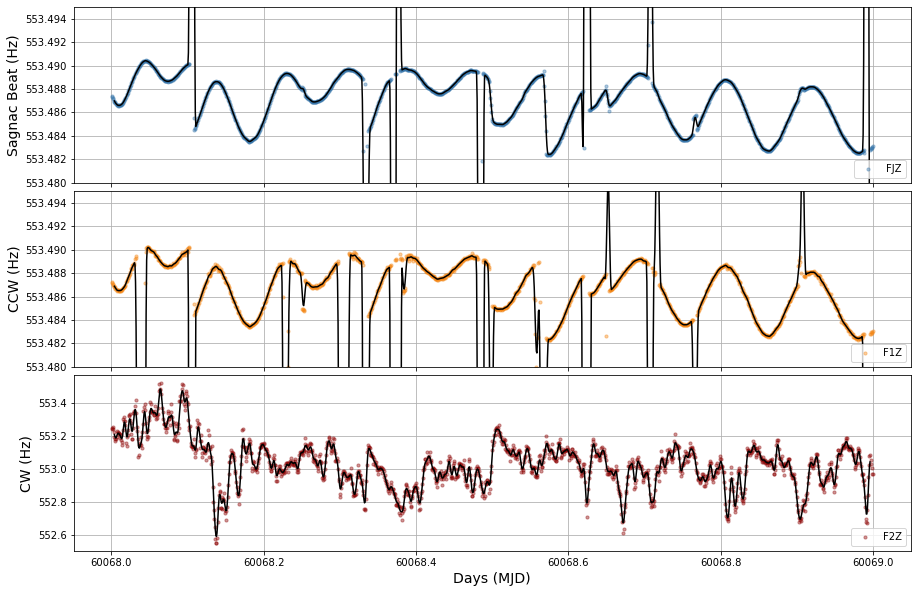

In [53]:
__makeplot(fjz, f1z, f2z)

## Cross-Correlation

In [37]:
def __makeplot_CC(df1, df2, df3):
    
    def __smooth(y, box_pts):
        from numpy import ones, convolve, hanning

#         win = ones(box_pts)/box_pts
        win = hanning(box_pts)
        y_smooth = convolve(y, win/sum(win), mode='same')

        return y_smooth
    
    time_scaling, time_unit = 1, "MJD"
    
    
    from scipy import signal
    from numpy import mean, nanmax, correlate, argmax, arange
    
    s1 = fjz.freqs - mean(fjz.freqs)
    s2 = f1z.freqs - mean(f1z.freqs)
    s3 = f1z.freqs - mean(f1z.freqs)


    corr1 = correlate(s1, s2, mode='same')
    corr1 /= nanmax(corr1)

    corr2 = correlate(s1, s3, mode='same')
    corr2 /= nanmax(corr2)
    
    xlags1 = arange(-corr1.size//2, corr1.size//2, 1)
    xlags2 = arange(-corr2.size//2, corr2.size//2, 1)
    
    cc1_max_x = xlags1[argmax(corr1)]
    cc2_max_x = xlags2[argmax(corr2)]
    
    print(cc1_max_x, cc2_max_x)
    
    ## ___________________
    ##
    
    fig, ax = plt.subplots(2,1, figsize=(15,7), sharex=False)
    
#     plt.subplots_adjust(hspace=0.05)
    
    font = 14
    smooting = 10
    cut_off = int(smooting/2)
    
    ## DF1
    ax[0].plot(df1['times_mjd']/time_scaling, df1['freqs'], c='k', alpha=0.4, zorder=2, label="FJZ")
    
    
    ## DF2
    ax[0].plot(df2['times_mjd']/time_scaling, df2['freqs'], c="#f48512", alpha=0.4, zorder=2, label="F1Z")


    ## DF3
    ax[0].plot(df2['times_mjd']/time_scaling, df3['freqs'], c="darkred", alpha=0.4, zorder=2, label="F2Z")


    ax[1].plot(xlags1, corr1, ls="--", label="FJZ-F1V")
    ax[1].plot(xlags2, corr2, ls=":", label="FJZ-F2V")
    

#     ax[0].set_ylim(553.462, 553.4725)
    
    
    ax[0].ticklabel_format(useOffset=False, style='plain')
    ax[1].ticklabel_format(useOffset=False, style='plain')

    
    ax[0].set_ylabel(r"Sagnac Beat (Hz)", fontsize=font)
    ax[1].set_ylabel(r"CC", fontsize=font)

    ax[1].set_xlabel("Days (MJD)", fontsize=font)
    
#     ax[0].set_title("ROMY-U Sagnac-Frequency", fontsize=font+2, pad=10)
    ax[0].legend(loc=1)
    ax[1].legend(loc=1)
    
    for i in range(2):
        ax[i].grid(zorder=0)
    
    plt.show();

5 5


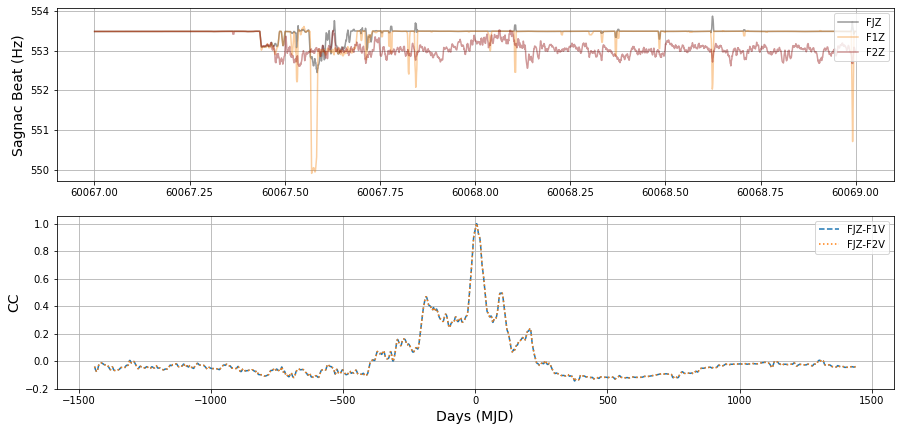

In [38]:
__makeplot_CC(fjz, f1z, f2z)

## Plot Power

In [35]:
def __makeplot_power(df1, df2, df3):
    
    def __smooth(y, box_pts):
        from numpy import ones, convolve, hanning

#         win = ones(box_pts)/box_pts
        win = hanning(box_pts)
        y_smooth = convolve(y, win/sum(win), mode='same')

        return y_smooth
    
    
    ## ___________________
    ##
    
    fig, ax = plt.subplots(2,1, figsize=(15,7), sharex=True)
    
    plt.subplots_adjust(hspace=0.05)
    
    font = 14
    smooting = 10
    cut_off = int(smooting/2)
    
    ## DF1
    ax[0].scatter(df1['times_mjd'], df1['psd_max'], c="#3776ab", s=10, alpha=0.4, zorder=2, label="FJZ")
#     ax[0].plot(df1['times_mjd'][cut_off:-cut_off]/time_scaling, __smooth(df1['freqs'],smooting)[cut_off:-cut_off], "k", zorder=2)
    
    
    ## DF2
    ax[1].scatter(df2['times_mjd'], df2['psd_max'], c="#f48512", s=10, alpha=0.4, zorder=2, label="F1Z*")
#     ax[1].plot(df2['times_mjd'][cut_off:-cut_off]/time_scaling, __smooth(df2['freqs'],smooting)[cut_off:-cut_off], "k", zorder=2)


    ## DF3
    ax[1].scatter(df2['times_mjd'], df3['psd_max'], c="darkred", s=10, alpha=0.4, zorder=2, label="F2Z")
#     ax[1].plot(df2['times_mjd'][cut_off:-cut_off]/time_scaling, __smooth(df3['freqs'],smooting)[cut_off:-cut_off], "k", zorder=2)


#     ax[2].set_ylim(5e12, 2e14)
        
#     ax[0].set_ylim(min(df1['freqs'][1:10]), max(df1['freqs'][1:10]))

#     ax[0].set_ylim(553.4550, 553.4655)
    
    
    ax[0].ticklabel_format(useOffset=False, style='plain')
    ax[1].ticklabel_format(useOffset=False, style='plain')
       
    ax[0].set_yscale("log")
    ax[1].set_yscale("log")
    
    ax[0].set_ylabel(r"PSD$_{max}$", fontsize=font)
    ax[1].set_ylabel(r"PSD$_{max}$", fontsize=font)

    ax[1].set_xlabel("Days (MJD)", fontsize=font)
    
#     ax[0].set_title("ROMY-U Sagnac-Frequency", fontsize=font+2, pad=10)
    ax[0].legend(loc=4)
    ax[1].legend(loc=4)
    
    for i in range(2):
        ax[i].grid(zorder=0)
    
    plt.show();

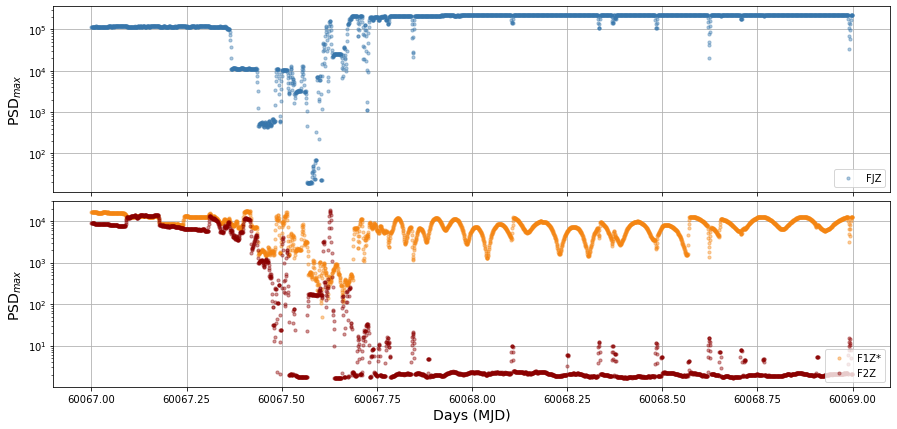

In [36]:
__makeplot_power(fjz, f1z, f2z)

## Plot Overview

In [116]:
from pandas import read_pickle

path = data_path+"sagnac_frequency/autodata/"

df = read_pickle(path+"FJZ_20230510.pkl")

df.sort_values(by="times_mjd", inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

df = df[(df.times_mjd > 60074) & (df.times_mjd < 60075)]

In [117]:
def __makeplot_overview(df):

    from matplotlib.gridspec import GridSpec
    from numpy import nanmean, nanmedian
    
    def __smooth(y, box_pts):
        from numpy import ones, convolve, hanning

#         win = ones(box_pts)/box_pts
        win = hanning(box_pts)
        y_smooth = convolve(y, win/sum(win), mode='same')

        return y_smooth
    
    
    time_scaling, time_unit = 1, "MJD"
    
    ## ___________________
    ##
    
    NN = 9
    font = 14
    smooting = 5
    cut_off = int(smooting/2)  
    
    
#     fig, ax = plt.subplots(NN, 1, figsize=(15,10), sharex=True)
#     plt.subplots_adjust(hspace=0.05)
    
    fig = plt.figure(figsize=(14,12))
    
    gs = GridSpec(NN, 2, figure=fig)
    
    ax1 = fig.add_subplot(gs[0:2, :])
    
    ax2 = fig.add_subplot(gs[2, :])
    ax3 = fig.add_subplot(gs[3, :])
    ax4 = fig.add_subplot(gs[4, :])
    
    ax5 = fig.add_subplot(gs[5:7, :])
    
    ax6 = fig.add_subplot(gs[7, :])
    ax7 = fig.add_subplot(gs[8, :])
        
    plt.subplots_adjust(hspace=0.1)
    
    ## Panel 1 -------------------------
    ax1.scatter(df['times_mjd']/time_scaling, df['fz'], c="tab:blue", s=7, alpha=0.4, zorder=2)
    ax1.plot(df['times_mjd'][cut_off:-cut_off]/time_scaling, __smooth(df['fz'],smooting)[cut_off:-cut_off], "tab:blue", lw=0.5, label="FJZ", zorder=2)
    
    ax1.scatter(df['times_mjd']/time_scaling, df['f1'], c="tab:orange", s=7, alpha=0.4, zorder=2)
    ax1.plot(df['times_mjd'][cut_off:-cut_off]/time_scaling, __smooth(df['f1'],smooting)[cut_off:-cut_off], "tab:orange", lw=0.5, label="CCW", zorder=2)
    
    ax1.scatter(df['times_mjd']/time_scaling, df['f2'], c="tab:red", s=7, alpha=0.4, zorder=2)
    ax1.plot(df['times_mjd'][cut_off:-cut_off]/time_scaling, __smooth(df['f2'],smooting)[cut_off:-cut_off], "tab:red", lw=0.5, label="CW", zorder=2)


    ## Panel 2-4 -------------------------
    ax2.scatter(df['times_mjd']/time_scaling, df['fz'], c="tab:blue", s=7, alpha=0.4, zorder=2)
#     ax2.plot(df['times_mjd'][cut_off:-cut_off]/time_scaling, __smooth(df['fz'],smooting)[cut_off:-cut_off], "tab:blue", lw=0.5, label="FJZ", zorder=2)
    
    ax3.scatter(df['times_mjd']/time_scaling, df['f1'], c="tab:orange", s=7, alpha=0.4, zorder=2)
#     ax3.plot(df['times_mjd'][cut_off:-cut_off]/time_scaling, __smooth(df['f1'],smooting)[cut_off:-cut_off], "tab:orange", lw=0.5, label="CCW", zorder=2)
    
    ax4.scatter(df['times_mjd']/time_scaling, df['f2'], c="tab:red", s=7, alpha=0.4, zorder=2)
#     ax4.plot(df['times_mjd'][cut_off:-cut_off]/time_scaling, __smooth(df['f2'],smooting)[cut_off:-cut_off], "tab:red", lw=0.5, label="CW", zorder=2)
   
        
    ## Panel 5 -------------------------
    ax5.scatter(df['times_mjd']/time_scaling, df['pz'], c="tab:blue", s=7, alpha=0.4, zorder=2)
    ax5.plot(df['times_mjd'][cut_off:-cut_off]/time_scaling, __smooth(df['pz'],smooting)[cut_off:-cut_off], "tab:blue", lw=0.5, label="FJZ", zorder=2)
                   
    ax5.scatter(df['times_mjd']/time_scaling, df['p1'], c="tab:orange", s=7, alpha=0.4, zorder=2)
    ax5.plot(df['times_mjd'][cut_off:-cut_off]/time_scaling, __smooth(df['p1'],smooting)[cut_off:-cut_off], "tab:orange", lw=0.5, label="CCW", zorder=2)
    
    ax5.scatter(df['times_mjd']/time_scaling, df['p2'], c="tab:red", s=7, alpha=0.4, zorder=2)
    ax5.plot(df['times_mjd'][cut_off:-cut_off]/time_scaling, __smooth(df['p2'],smooting)[cut_off:-cut_off], "tab:red", lw=0.5, label="CW", zorder=2)
                  
        
    ## Panel 6 -------------------------
    ax6.scatter(df['times_mjd']/time_scaling, df['ac_z'], c="tab:green", s=7, alpha=0.4, zorder=2)
    ax6.plot(df['times_mjd'][cut_off:-cut_off]/time_scaling, __smooth(df['ac_z'],smooting)[cut_off:-cut_off], "tab:green", lw=0.5, label="AC", zorder=2)
       
    ax6.scatter(df['times_mjd']/time_scaling, df['dc_z'], c="tab:pink", s=7, alpha=0.4, zorder=2)
    ax6.plot(df['times_mjd'][cut_off:-cut_off]/time_scaling, __smooth(df['dc_z'],smooting)[cut_off:-cut_off], "tab:pink", lw=0.5, label="DC", zorder=2)
       
        
        
    ## Panel 7 -------------------------
    ax7.scatter(df['times_mjd']/time_scaling, df['contrast_z'], c="tab:purple", s=7, alpha=0.4, zorder=2)
    ax7.plot(df['times_mjd'][cut_off:-cut_off]/time_scaling, __smooth(df['contrast_z'],smooting)[cut_off:-cut_off], "tab:purple", lw=0.5, label="FJZ", zorder=2)
         
        
        
    ax5.set_yscale("log")
    
    ax2.set_ylim(0.99999*nanmedian(df.fz), 1.00001*nanmedian(df.fz))
    ax3.set_ylim(0.99998*nanmedian(df.fz), 1.00002*nanmedian(df.fz))
    ax4.set_ylim(0.99998*nanmedian(df.fz), 1.00002*nanmedian(df.fz))
    ax7.set_ylim(0, 3*nanmedian(df.contrast_z))
    
    ax2.ticklabel_format(useOffset=False, style='plain')
    ax3.ticklabel_format(useOffset=False, style='plain')
    ax4.ticklabel_format(useOffset=False, style='plain')
    
    
    ax1.set(xticklabels=[]) 
    ax2.set(xticklabels=[]) 
    ax3.set(xticklabels=[]) 
    ax4.set(xticklabels=[])    
    
    ax1.set_ylabel(r"Sagnac Beat (Hz)", fontsize=font)
    ax2.set_ylabel(r"FZ (Hz)", fontsize=font)
    ax3.set_ylabel(r"CW (Hz)", fontsize=font)
    ax4.set_ylabel(r"CCW (Hz)", fontsize=font)
    ax5.set_ylabel(r"max. Power (V$^2$/Hz)", fontsize=font)
    ax6.set_ylabel(r"signal(V)", fontsize=font)
    ax7.set_ylabel(r"contrast", fontsize=font)

    ax7.ticklabel_format(axis="x", useOffset=False, style='plain')
    ax7.set_xlabel("Days (MJD)", fontsize=font)
    
    ax1.set_title("ROMY-Z Sagnac-Frequency ", fontsize=font+1, pad=10)
    
    ax1.legend(ncol=3)
    ax5.legend(ncol=3)
    ax6.legend(ncol=2)

    for ax in [ax1, ax2, ax3, ax4, ax5, ax6, ax7]:
        ax.grid(alpha=0.8, ls=":", zorder=0)

    plt.show();

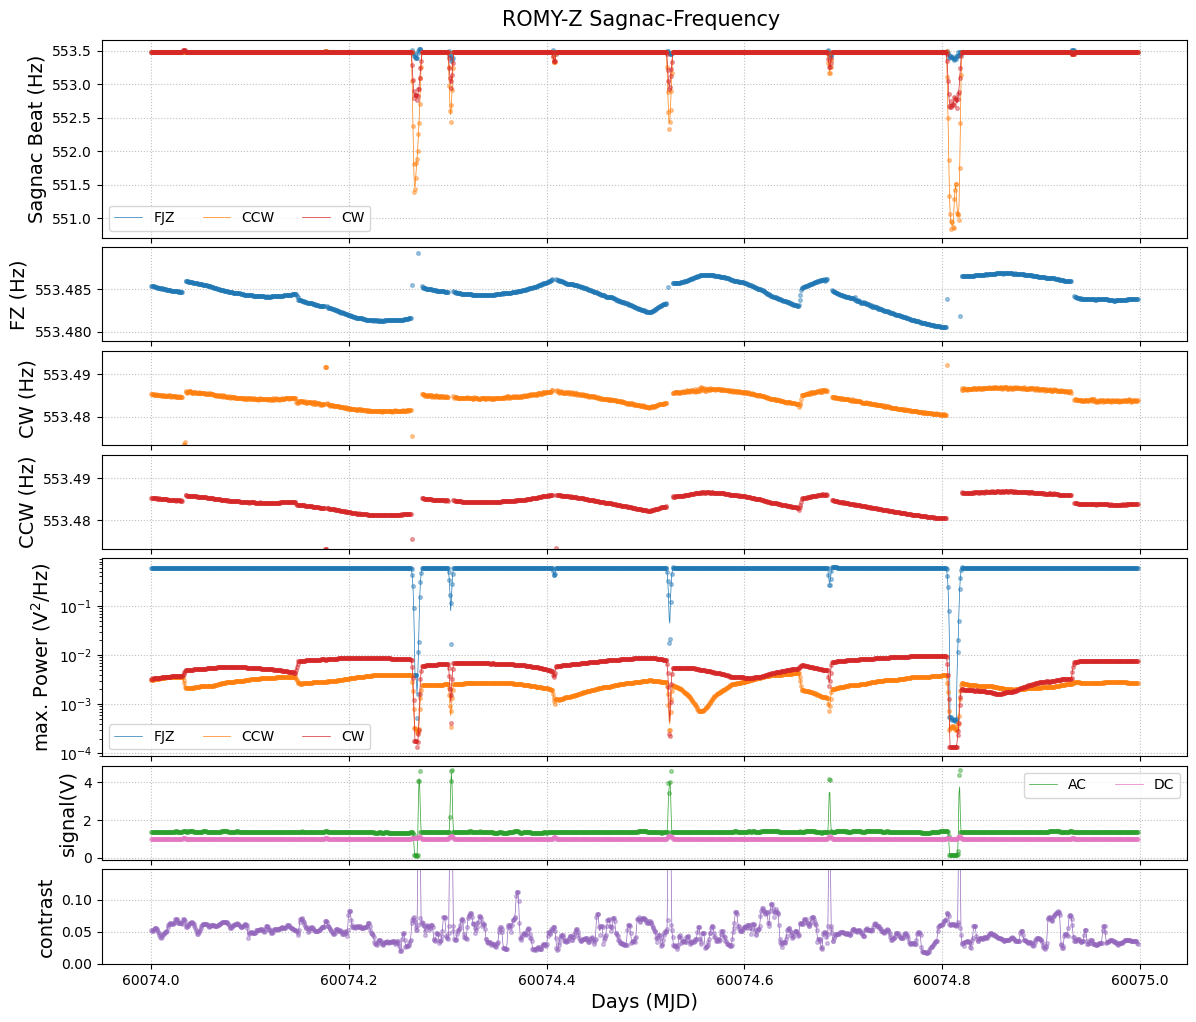

In [118]:
__makeplot_overview(df)